In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
from torchvision import datasets, transforms
data_path = './data/'
mnist_train = datasets.MNIST(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]))

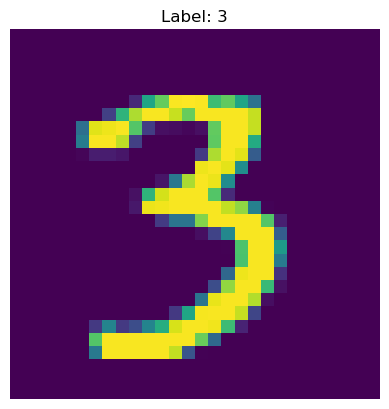

(tensor(0.1424), tensor(0.3216), tensor(0.), tensor(1.))

In [3]:
import matplotlib.pyplot as plt

# Select a random image from the dataset
index = 10000
image, label = mnist_train[index]

# Plot the image
plt.imshow(image.squeeze())
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()
image.mean(), image.std(), image.min(), image.max()


In [16]:
imgs = torch.stack([img for img, _ in mnist_train], dim = 3)
imgs.shape, imgs.view(1,-1)[:,:50].shape

(torch.Size([1, 28, 28, 60000]), torch.Size([1, 50]))

In [18]:
mean = imgs.view(1,-1).mean(dim=1).item()
std = imgs.view(1,-1).std().item()
mean, std

(3.720237984339292e-08, 0.9999999403953552)

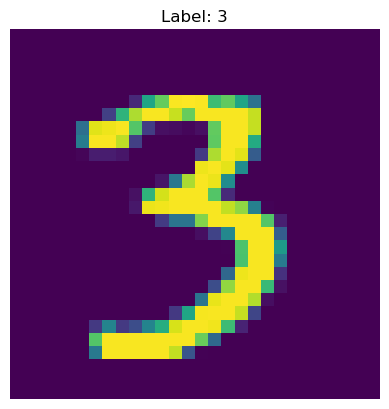

(tensor(0.1424), tensor(0.3216), tensor(-3.7202e-08), tensor(1.))

In [19]:
from torchvision import datasets, transforms
data_path = './data/'
mnist_train = datasets.MNIST(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean), (std))
    ]))

index = 10000
image2, label = mnist_train[index]

# Plot the image
plt.imshow(image.squeeze())
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()
image2.mean(), image2.std(), image2.min(), image2.max()